In [1]:
import os
from datetime import datetime

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [2]:
from model import AutoFormer
from datasets import CustomDataset
from utils.data import split_data, get_day_features, scale_data
from utils.tools import EarlyStopping, adjust_learning_rate
from utils.train import train_step, val_step, test

In [3]:
# Global Constants
CSV_PATH = "data/canadian_weather/weather_data.csv"
MD_CSV_PATH = "data/canadian_weather/station_metadata.csv"

TRAIN_PERC = .7
TEST_PERC = .1
BATCH_SIZE = 32

SEQ_LEN = 96 #Input Sequence Length
START_TOKEN_LEN = 48 #Start Token Length
PRED_LEN = 96 #Prediction sequence length
FEATURES = "M"

EPOCHS = 50
LR = .0001
LRADJ = "type1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 ## Prepare Data

In [4]:
# Read Data
df = pd.read_csv(CSV_PATH)
df

,LOCAL_DATE,BROCKVILLE PCC;MEAN_TEMPERATURE,BROCKVILLE PCC;MIN_TEMPERATURE,BROCKVILLE PCC;MAX_TEMPERATURE,BROCKVILLE PCC;TOTAL_PRECIPITATION,POWELL RIVER A;MEAN_TEMPERATURE,POWELL RIVER A;MIN_TEMPERATURE,POWELL RIVER A;MAX_TEMPERATURE,POWELL RIVER A;TOTAL_PRECIPITATION,STONY MOUNTAIN;MEAN_TEMPERATURE,...,CHATHAM POINT;MAX_TEMPERATURE,CHATHAM POINT;TOTAL_PRECIPITATION,GREENWOOD A;MEAN_TEMPERATURE,GREENWOOD A;MIN_TEMPERATURE,GREENWOOD A;MAX_TEMPERATURE,GREENWOOD A;TOTAL_PRECIPITATION,BROOKS;MEAN_TEMPERATURE,BROOKS;MIN_TEMPERATURE,BROOKS;MAX_TEMPERATURE,BROOKS;TOTAL_PRECIPITATION
0,1990-01-01,-5.000,-10.000,0.000,0.000,3.600,2.000,5.200,0.000,-13.000,...,3.500,1.200,2.200,-5.000,9.300,8.400,0.500,-2.200,3.100,0.000
1,1990-01-02,-4.000,-9.000,1.000,0.000,0.900,-2.000,3.800,1.800,-10.500,...,4.200,13.200,-3.300,-8.000,1.400,0.000,-8.600,-15.200,-1.900,0.000
2,1990-01-03,0.500,-4.000,5.000,0.000,3.700,1.900,5.500,3.200,-15.000,...,5.500,20.200,-1.700,-6.400,3.100,0.000,-7.100,-15.400,1.200,0.000
3,1990-01-04,4.000,2.000,6.000,2.400,5.900,3.800,8.000,1.000,-21.000,...,6.900,11.800,-0.300,-7.100,6.600,3.000,-12.300,-15.100,-9.400,0.000
4,1990-01-05,-3.000,-4.000,-2.000,0.000,5.700,2.200,9.200,14.000,-18.500,...,8.500,34.200,-0.700,-8.000,6.600,0.000,-10.300,-15.100,-5.400,0.700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11684,2021-12-28,-3.000,-9.000,3.000,0.000,-5.000,-7.000,-3.000,0.600,-22.000,...,-3.000,0.000,-2.400,-7.200,2.500,4.200,-27.300,-37.300,-17.400,0.200
11685,2021-12-29,-2.500,-4.000,-1.000,0.000,-7.500,-12.000,-3.000,8.000,-30.000,...,-1.500,5.000,0.200,-1.500,1.800,0.400,-24.000,-27.700,-20.200,0.000
11686,2021-12-30,-1.000,-3.000,1.000,0.000,-3.300,-5.000,-1.500,0.000,-29.500,...,0.000,0.000,0.400,-1.500,2.200,0.000,-24.900,-31.300,-18.600,0.200
11687,2021-12-31,NaN,NaN,NaN,NaN,-6.000,-10.500,-1.500,0.000,-31.500,...,-0.500,0.000,0.900,0.000,1.800,3.000,-27.300,-33.300,-21.300,0.000


In [5]:
# FIll nan with last valid observation 
df.fillna(df.mean(), inplace=True)

/tmp/ipykernel_6539/3227414236.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)


In [6]:
md_df = pd.read_csv(MD_CSV_PATH)
md_df

,Unnamed: 0,x,y,STATION_NAME,FILENAME,PROVINCE_CODE,min_date,max_date,mean_temp_coverage,max_temp_coverage,total_precipitation_coverage,direction_max_gust_coverage,speed_max_gust_coverage,min_rel_humiudity_coverage,max_rel_humiudity_coverage
0,0,-75.667,44.600,BROCKVILLE PCC,station_4236_data.csv,ON,1990-01-01,2022-01-01,0.999,1.000,0.999,0.000,0.000,0.000,0.000
1,1,-124.500,49.834,POWELL RIVER A,station_327_data.csv,BC,1990-01-01,2022-01-01,0.983,0.983,1.000,0.000,0.000,0.000,0.000
2,2,-97.167,50.117,STONY MOUNTAIN,station_3678_data.csv,MB,1990-01-01,2022-01-01,1.000,1.000,1.000,0.000,0.000,0.000,0.000
3,3,-82.933,42.333,WINDSOR RIVERSIDE,station_4715_data.csv,ON,1993-12-01,2022-01-01,1.000,1.000,1.000,0.000,0.000,0.000,0.000
4,5,-77.533,44.117,TRENTON A,station_5126_data.csv,ON,1990-01-01,2022-01-01,0.953,0.953,0.953,0.890,0.900,0.926,0.927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,106,-93.967,48.633,BARWICK,station_3932_data.csv,ON,1990-01-01,2022-01-01,0.999,0.999,1.000,0.000,0.000,0.000,0.000
105,107,-110.283,54.417,COLD LAKE A,station_2832_data.csv,AB,1990-01-01,2022-01-01,1.000,1.000,1.000,0.909,0.927,0.999,0.999
106,108,-125.446,50.333,CHATHAM POINT,station_153_data.csv,BC,1990-01-01,2022-01-01,0.999,1.000,1.000,0.000,0.000,0.000,0.000
107,109,-64.917,44.983,GREENWOOD A,station_6354_data.csv,NS,1990-01-01,2022-01-01,1.000,1.000,1.000,0.966,0.966,0.998,0.999


In [7]:
# Carve out date index and features
dates = pd.to_datetime(df.iloc[:, 0])
data = df.iloc[:, 1:].values
col_name_list = df.columns[1:]

# Scale between 0 and 1
data = (data - np.amin(data)) / (np.amax(data) - np.amin(data))

In [8]:
(train_data, train_dates), (val_data, val_dates), (test_data, test_dates) = split_data(data, dates, TRAIN_PERC, TEST_PERC)

train_time_feat = get_day_features(train_dates)
val_time_feat = get_day_features(val_dates)
test_time_feat = get_day_features(test_dates)

train_data = scale_data(train_data) 
val_data = scale_data(val_data)
test_data = scale_data(test_data)

In [9]:
print("train", train_data.shape, train_time_feat.shape)
train_dataset = CustomDataset(data=train_data,
                                   time_feat=train_time_feat,
                                   seq_len=SEQ_LEN,
                                   start_token_len=START_TOKEN_LEN,
                                   pred_len=PRED_LEN
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)

print("validation", val_data.shape, val_time_feat.shape)
val_dataset = CustomDataset(data=val_data,
                                   time_feat=val_time_feat,
                                   seq_len=SEQ_LEN,
                                   start_token_len=START_TOKEN_LEN,
                                   pred_len=PRED_LEN
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, drop_last=True)
print("test", test_data.shape, test_time_feat.shape)

test_dataset = CustomDataset(data=test_data,
                                   time_feat=test_time_feat,
                                   seq_len=SEQ_LEN,
                                   start_token_len=START_TOKEN_LEN,
                                   pred_len=PRED_LEN
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True)

train (8182, 428) (8182, 3)
validation (2339, 428) (2339, 3)
test (1168, 428) (1168, 3)


 ## Prepare Model

In [10]:
af_model = AutoFormer(enc_in=428, dec_in=428, c_out=428, factor=3)
opt = torch.optim.Adam(af_model.parameters(), lr=.0001)
criterion = torch.nn.MSELoss()

af_model.to(DEVICE)

AutoFormer(
  (decomp): SeriesDecomp(
    (moving_avg): MovingAvg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(428, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=3, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(428, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=3, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder):

## Train and Validate

In [11]:
#Train Step
run_name = f"run_{str(datetime.now().strftime('%s'))}"

path = os.path.join("./checkpoints/", run_name)
if not os.path.exists(path):
    os.makedirs(path)

train_steps = len(train_loader)
early_stopping = EarlyStopping(patience=1, verbose=True)

model_optim = optim.Adam(af_model.parameters(), lr=LR)
criterion = nn.MSELoss()

train_loss_list = []
val_loss_list = []
for epoch in range(EPOCHS):
    train_loss = train_step(af_model, train_loader, model_optim, criterion, DEVICE, PRED_LEN, START_TOKEN_LEN)
    val_loss = val_step(af_model, val_loader, criterion, DEVICE, PRED_LEN, START_TOKEN_LEN)

    early_stopping(val_loss, af_model, path)
    if early_stopping.early_stop:
        print("Early Stopping")
        break
    
    adjust_learning_rate(model_optim, epoch+1, adjust_type="type1", lr=LR)
    
    print(epoch, train_loss, val_loss)
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)



Validation loss decreased (inf --> 1.042263).  Saving model ...
Updating learning rate to 0.0001
0 1.2028318298868386 1.0422632
Validation loss decreased (1.042263 --> 0.921983).  Saving model ...
Updating learning rate to 5e-05
1 0.9540767212469415 0.92198336
Validation loss decreased (0.921983 --> 0.864936).  Saving model ...
Updating learning rate to 2.5e-05
2 0.809120949013645 0.8649355
Validation loss decreased (0.864936 --> 0.806237).  Saving model ...
Updating learning rate to 1.25e-05
3 0.7108258457787066 0.8062374
Validation loss decreased (0.806237 --> 0.775615).  Saving model ...
Updating learning rate to 6.25e-06
4 0.6528963984016434 0.7756146
Validation loss decreased (0.775615 --> 0.762672).  Saving model ...
Updating learning rate to 3.125e-06
5 0.6296738542945509 0.76267177
Validation loss decreased (0.762672 --> 0.758900).  Saving model ...
Updating learning rate to 1.5625e-06
6 0.6198331909964842 0.75889957
Validation loss decreased (0.758900 --> 0.756783).  Saving mo

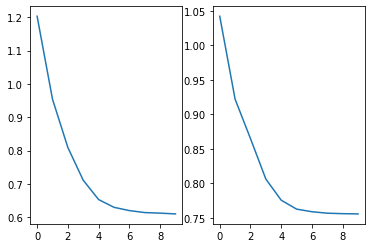

In [12]:
f, axarr = plt.subplots(1, 2)

x_index = [i for i in range(len(train_loss_list))]

axarr[0].plot(x_index, train_loss_list)
axarr[1].plot(x_index, val_loss_list)

## Test and visualize predicitons

In [13]:
input, pred, true = test(af_model, test_loader, run_name, DEVICE, PRED_LEN, START_TOKEN_LEN)
print(input.shape, pred.shape, true.shape)

test shape: (30, 32, 96, 428) (30, 32, 96, 428)
test shape: (960, 96, 428) (960, 96, 428)
mse:0.7164250612258911, mae:0.6006863713264465
(960, 96, 428) (960, 96, 428) (960, 96, 428)


In [16]:
ss_indices = np.random.choice(range(pred.shape[0]), 2, replace=False)
ss_pred = pred[ss_indices]
ss_true = true[ss_indices]
ss_input = input[ss_indices]

col_indices = list(np.random.choice(range(ss_pred.shape[2]), 10, replace=False))
print(len(col_indices), ss_pred.shape, ss_true.shape, ss_input.shape)

10 (2, 96, 428) (2, 96, 428) (2, 96, 428)


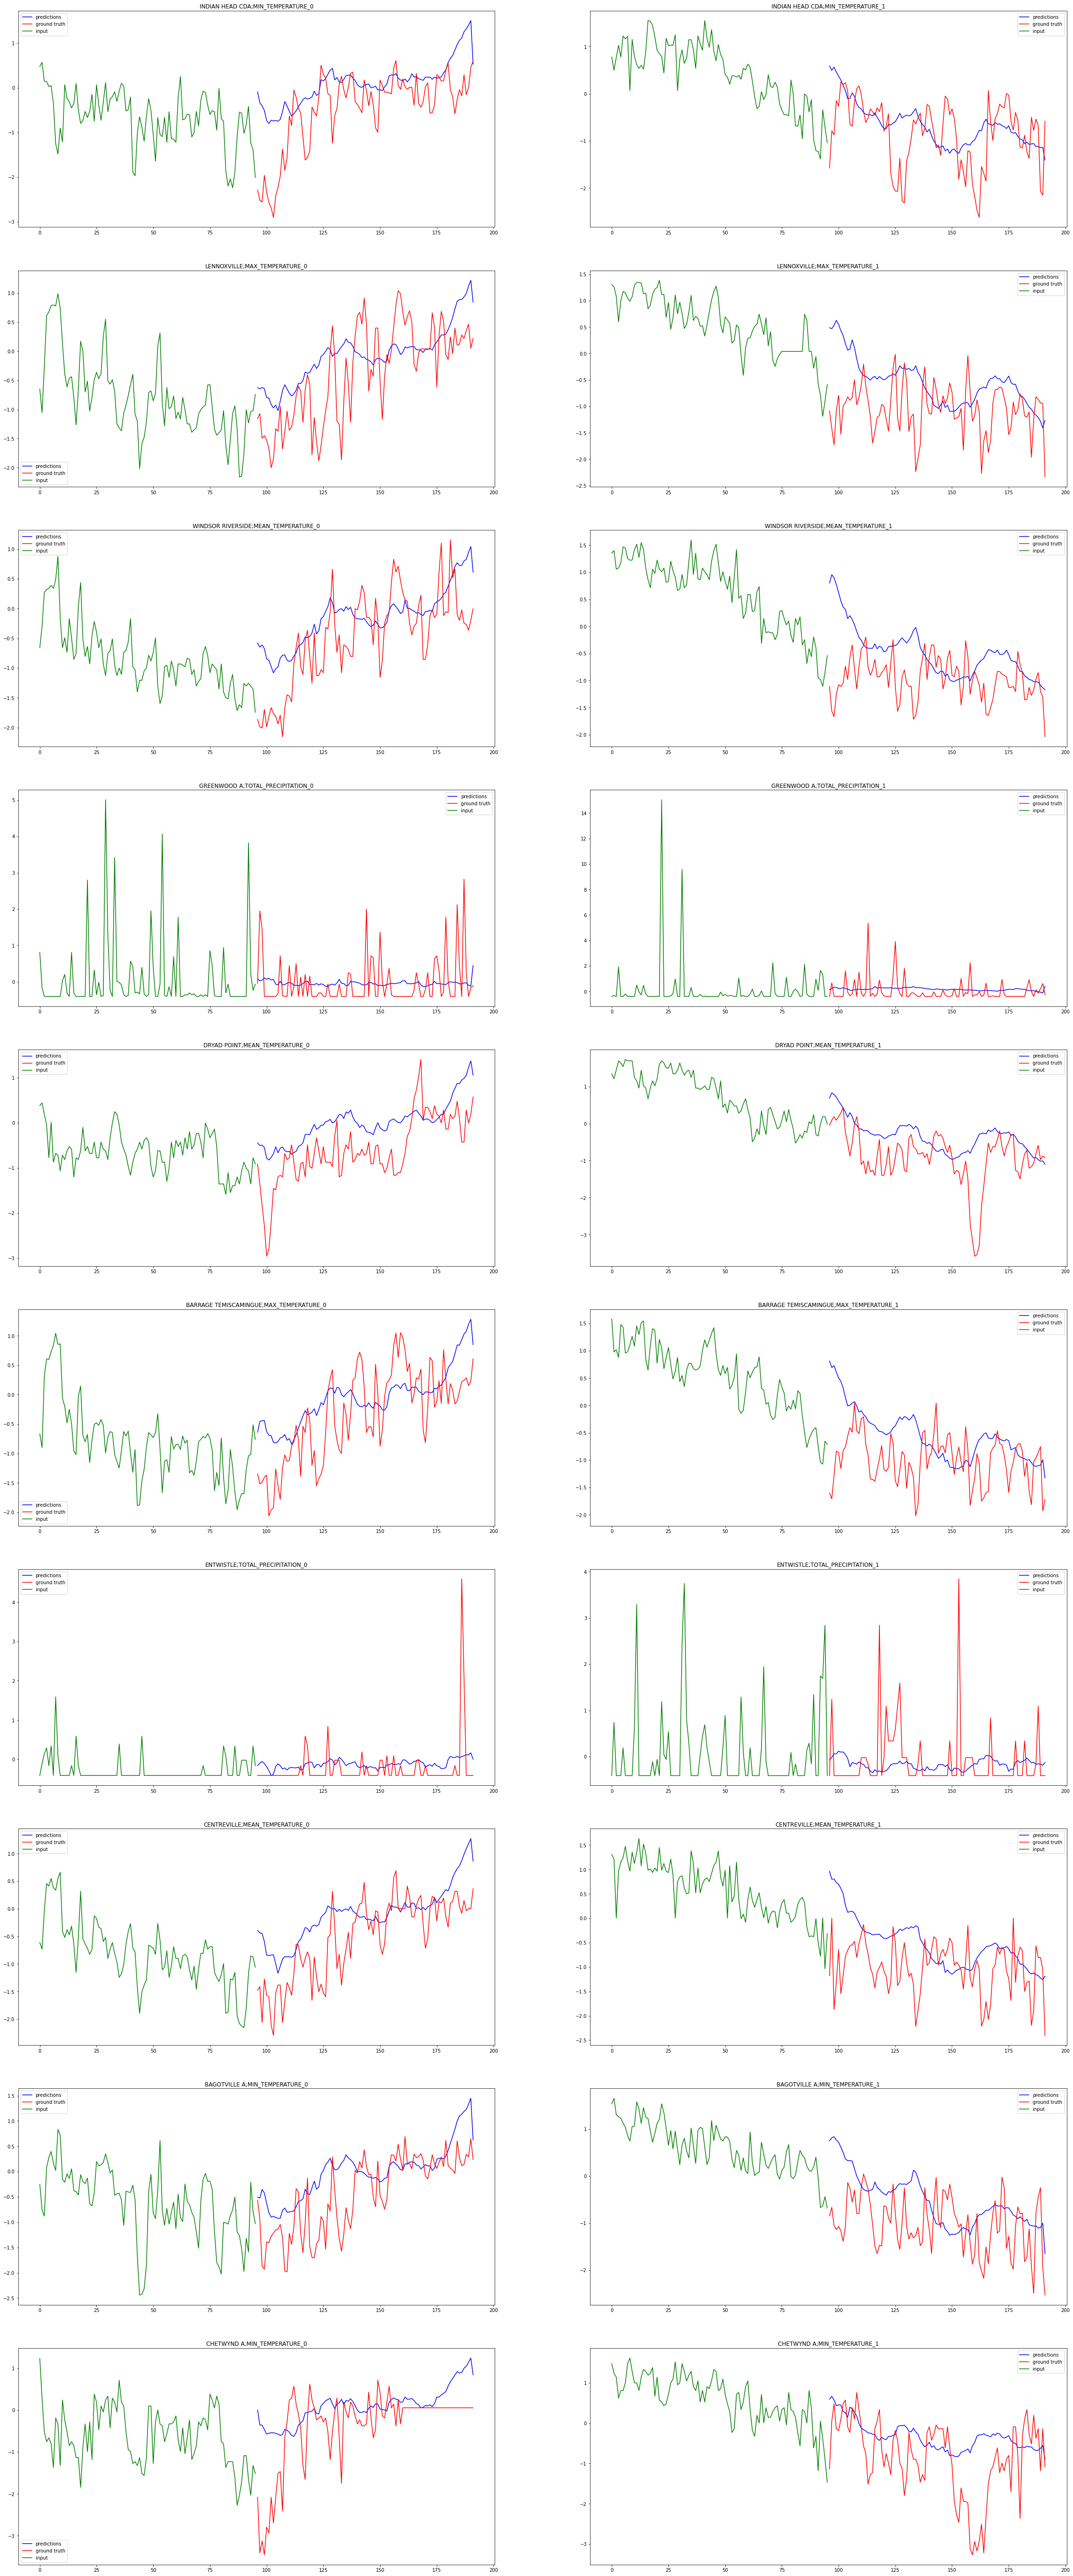

In [17]:
f, axarr = plt.subplots(len(col_indices), ss_pred.shape[0], figsize=(40, 100))
for fig_x, i in enumerate(col_indices):
    series_preds = ss_pred[:, :, i].squeeze()
    series_trues = ss_true[:, :, i].squeeze()
    series_inputs = ss_input[:, :, i].squeeze()
    for j in range(ss_pred.shape[0]):
        series_pred = series_preds[j, :].squeeze()
        series_true = series_trues[j, :].squeeze()
        series_input = series_inputs[j, :].squeeze()
        input_len = series_input.shape[0]
        pred_gt_len = series_pred.shape[0]
        input_x = np.array([i for i in range(input_len)])
        x = np.array([i for i in range(input_len, input_len+pred_gt_len)])
        axarr[fig_x, j].plot(x, series_pred, c="blue", label="predictions")
        axarr[fig_x, j].plot(x, series_true, c="red", label="ground truth")
        axarr[fig_x, j].plot(input_x, series_input, c="green", label="input")
        axarr[fig_x, j].legend()
        axarr[fig_x, j].set_title(f"{col_name_list[i]}_{str(j)}")


In [18]:
f.savefig("candadian_weather.png")